In [1]:
#default_exp ocr_attention_training

In [1]:
#export
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#export
from ocr.core import save_inference, load_inference, plot
from ocr.ocr_dataset_sroie2019 import create_df as create_sroie_df
from ocr.ocr_dataset_sroie2019 import sroie_ocr_config, DATA_PATH, char_freq
PAD = sroie_ocr_config.PAD # PAD - how much is data padded

In [4]:
#export
allowed_chars = {';', 'Q', 'H', '-', ']', 'P', 'L', 'E', '{', ',', '[', 'X', '4', 'K', '@', '&', '(', 
                 '0', '}', '.', '?', '\n', 'J', '|', '$', '*', 'D', '6', 'S', '~', '8', '2', '>', ' ', 
                 'W', 'A', 'V', '/', '_', 'N', 'R', '=', '#', 'O', '7', "'", 'Y', '5', 'U', 'T', '+', 
                 '\\', '1', 'I', ':', 'M', 'C', '9', '%', '"', 'B', '!', '^', 'G', '<', 'Z', '3', ')', 'F'}

class attention_config:
    LINE_HEIGHT = 48
    USE_DEFAULT_CLASSES = True # uses only allowed chars
    label_delim = '`'
    allowed_chars = allowed_chars

### Prep

In [5]:
print(char_freq)

{'`': 1, '·': 1, '{': 3, '}': 3, '\\': 6, '|': 6, ';': 12, '<': 13, '>': 15, '^': 19, '_': 19, '\n': 20, '~': 24, '?': 26, '[': 66, ']': 66, '"': 166, '+': 229, '=': 324, '!': 381, "'": 408, '#': 625, '$': 648, '&': 707, 'Z': 768, '@': 1165, 'Q': 1167, '*': 1473, '%': 1831, 'W': 2910, 'J': 2992, 'V': 3438, '/': 3797, 'F': 3843, ',': 4191, 'X': 4732, ')': 4751, '(': 4766, 'K': 4998, '-': 5566, 'Y': 6216, 'B': 6544, '9': 7544, '7': 8285, '8': 9326, 'P': 9432, '4': 9437, '6': 9660, 'H': 9737, ':': 10516, '5': 10837, '3': 11966, 'G': 12409, 'U': 12589, 'D': 12721, 'C': 14645, '2': 15001, 'M': 15211, 'L': 17481, '.': 19307, 'I': 21104, '1': 22127, 'R': 23724, 'O': 25649, 'N': 26187, 'S': 28138, 'E': 30652, 'T': 32246, 'A': 40094, '0': 42829, ' ': 64128}


In [6]:
chars = list(char_freq.keys())
label_delim = attention_config.label_delim
label_delim in chars

True

In [7]:
allowed_chars = set(chars) - set(['·', label_delim])
print(allowed_chars)
len(allowed_chars)

{'#', 'W', '@', '.', 'L', '\\', '9', 'Z', '6', '1', ' ', 'Q', '/', '^', '&', '~', '3', 'I', '$', '\n', '4', 'V', ';', 'B', 'P', 'C', 'M', ')', 'K', '{', 'Y', 'U', "'", 'F', 'S', 'H', '!', 'T', 'J', '<', '>', '?', 'G', '8', '=', ':', '2', 'A', 'O', '_', 'X', '(', '"', 'R', '%', ',', '7', '5', '}', '+', 'E', '|', '*', ']', '0', '-', 'N', 'D', '['}


69

In [8]:
split_chars = lambda string, delim: ''.join([char+delim for char in string])[:-1]

def preprocess_string(string):
    string = string.replace('·', '.')
    string = string.replace('`', "'")
    string = split_chars(string, attention_config.label_delim)
    return string

split_chars('qwerty', label_delim)

'q`w`e`r`t`y'

In [9]:
sroie_df = create_sroie_df()
sroie_df.head()

,image_path,string,valid,dataset
0,X51006327978.0.jpg,Y SOON FATT S/B (81497-P),False,sroie2019
1,X51006327978.1.jpg,"LOT 1504, BATU 8 1/2, JALAN KLANG LAMA,",False,sroie2019
2,X51006327978.2.jpg,"46000 PETALING JAYA, SELANGOR.",False,sroie2019
3,X51006327978.3.jpg,TEL : 016-2014209,False,sroie2019
4,X51006327978.4.jpg,GST REG NO : 000788250624,False,sroie2019


In [10]:
main_df = sroie_df

In [11]:
main_df['string'] = main_df['string'].map(preprocess_string)
main_df.head()

,image_path,string,valid,dataset
0,X51006327978.0.jpg,Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`9`7`-`P`),False,sroie2019
1,X51006327978.1.jpg,"L`O`T` `1`5`0`4`,` `B`A`T`U` `8` `1`/`2`,` `J`...",False,sroie2019
2,X51006327978.2.jpg,"4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,` `S`E`...",False,sroie2019
3,X51006327978.3.jpg,T`E`L` `:` `0`1`6`-`2`0`1`4`2`0`9,False,sroie2019
4,X51006327978.4.jpg,G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`5`0`6`2`4,False,sroie2019


In [12]:
sparse_df = pd.concat([ main_df[ main_df['valid'] == False ].iloc[0:10000:2], main_df[ main_df['valid'] == True ].iloc[:500] ])
sparse_df.head()

,image_path,string,valid,dataset
0,X51006327978.0.jpg,Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`9`7`-`P`),False,sroie2019
2,X51006327978.2.jpg,"4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,` `S`E`...",False,sroie2019
4,X51006327978.4.jpg,G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`5`0`6`2`4,False,sroie2019
6,X51006327978.6.jpg,D`E`S`C,False,sroie2019
8,X51006327978.8.jpg,P`R`I`C`E,False,sroie2019


### Databunch

In [13]:
#export
# label_delim = '`' # '<pad>''

class MultiCategoryProcessor(PreProcessor):
    "`PreProcessor` that create `classes` from `ds.items` and handle the mapping."
    def __init__(self, ds:ItemList):
        self.create_classes(ds.classes)
        self.use_default_classes = attention_config.USE_DEFAULT_CLASSES
        self.default_classes = attention_config.allowed_chars
        
    def create_classes(self, classes):
        self.classes = classes
        if classes is not None: self.c2i = {v:k for k,v in enumerate(classes)}

    def process_one(self,item):
        ''' list of chars from `MultiCategoryList.get()` '''
        return [ self.c2i[c] if c in self.c2i else 0 for c in item ]
    
    def process(self, ds):
        if self.classes is None: self.create_classes(self.generate_classes(ds.items))
        ds.classes = self.classes
        ds.c2i = self.c2i
        super().process(ds)

    def generate_classes(self, items):
        ''' items = [ ['h', 'e', 'l', 'l', 'o'], [...], ...] '''
        "Generate classes from `items` by taking the sorted unique values."
        if self.use_default_classes:
            classes = list(self.default_classes)
        else:
            classes = set()
            for c in items: classes = classes.union(set(c))
            classes = list(classes)
        classes.sort()
        return [attention_config.label_delim] + classes # CHANGED

In [14]:
#export
class MultiCategory(ItemBase):
    "Basic class for multi-classification labels."
    def __init__(self, data, obj, raw): self.data, self.obj, self.raw = data, obj, raw
    def __str__(self):  return attention_config.label_delim.join([str(o) for o in self.obj])
    def __hash__(self): return hash(str(self))

In [15]:
#export
def one_hot_text(x:Collection[int], c:int):
    "One-hot encode `x` with `c` classes."
    ''' x w/ len of n returns [n,c] shape arr '''
    res = np.zeros((len(x),c), np.float32)
    res[np.arange(len(x)), listify(x)] = 1.
    return res

In [16]:
#export
class MultiCategoryList(ItemList):
    "Basic `ItemList` for multi-classification labels."
    _processor = MultiCategoryProcessor
    def __init__(self, items:Iterator, classes:Collection=None, label_delim:str=None, one_hot:bool=False, **kwargs):
        self.classes = classes
        items = [line.split(attention_config.label_delim) for line in items] # CHANGED
        super().__init__(items, **kwargs)
        self.processor = [MultiCategoryProcessor(self)]

    def get(self, i):
        o = self.items[i] # list of ints that represent chars
        return MultiCategory(tensor(o), [self.classes[p] for p in o], o) # CHANGED

    def analyze_pred(self, pred, thresh:float=0.5):
        return (pred >= thresh).float()

    def reconstruct(self, data_out):
        if isinstance(data_out, list): # output of data
            t_argmax, _, lengths = data_out
        else: # output from nn
#             t_argmax = torch.argmax(data_out, axis=-1) # CHANGED
            t_argmax = data_out # CHANGED
#         t = data_out[0] if isinstance(data_out, list) else data_out # if train mode it returns tuple
        ''' t [n,c] tensor '''
        o = [int(i) for i in t_argmax] # CHANGED
        return MultiCategory(one_hot_text(o, self.c), [self.classes[p] for p in o], o)
    
    @property
    def c(self): return len(self.classes)

In [17]:
#export
def str2lines(string, n=50):
    return ''.join([s+'\n' if (i+1)%n == 0 else s for i,s in enumerate(string)])

str2lines('asdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasd')

'asdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdas\ndasdasdasdasdasdasdasd'

In [18]:
#export
class MyImageList(ImageList):
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, 1, imgsize=imgsize, figsize=figsize) # CHANGED rows -> 1
        for x,y,ax in zip(xs, ys, axs.flatten()): x.show(ax=ax, y=y, **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()
        
    def show_xyzs(self, xs, ys, zs, imgsize:int=20, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
#         if self._square_show_res:
        title = 'Ground truth\nPredictions'
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, 1, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12) # CHANGED rows -> 1
        for x,y,z,ax in zip(xs,ys,zs,axs.flatten()):
            x.show(ax=ax, title=f'y_true: {str2lines(str(y))}\n\ny_pred: {str2lines(str(z))}', **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
#         else:
#             title = 'Ground truth/Predictions'
#             axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
#             for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
#                 x.show(ax=axs[i,0], y=y, **kwargs)
#                 x.show(ax=axs[i,1], y=z, **kwargs)

In [19]:
#export
def _gaussian_blur(x, size:uniform_int):
    blurred = cv2.blur(image2np(x), (size,size)) # np.arr
#     blurred = cv2.GaussianBlur(image2np(x), (size,size), 0)
    return tensor(blurred).permute(2,0,1)

def gaussian_blur(size, p=1.0):
    return RandTransform(tfm=TfmPixel(_gaussian_blur), kwargs={'size':size}, p=p, resolved={}, do_run=True, is_random=True, use_on_y=False)

In [20]:
#export
resize_one_img = lambda x, size: F.interpolate(x[None], size=size, mode='bilinear', align_corners=True)[0]

def resize_tfm(x, pad:uniform_int, line_height=attention_config.LINE_HEIGHT):
    ''' size of subtracted padding '''
    c,h,w = x.shape
    x = x[ : , pad:h-pad , pad:w-pad ]
    new_w = int(w * line_height / float(h))
    return resize_one_img(x, size=(line_height, new_w))

def rand_resize(pad, p=1.0):
    return RandTransform(tfm=TfmPixel(resize_tfm), kwargs={'pad':pad}, p=p, resolved={}, do_run=True, is_random=True, use_on_y=False)

In [21]:
#export
train_transforms = [
    rand_resize(pad=(0,PAD), p=1.0),
    rotate(degrees=(-2, 2), p=0.6),
    symmetric_warp(magnitude=(-0.03, 0.03), p=0.1),
    rand_zoom(scale=(0.9,1.03), p=0.5),
    brightness(change=(0.35, 0.65), p=0.4),
    contrast(scale=(0.7,1.3), p=0.4),
    gaussian_blur(size=(1, 7), p=0.2),
#     squish(scale=(0.85,1.15), p=0.3),
    cutout(n_holes=(0,6), length=(1,10)), # black rect
#     tilt(direction=(0,3), magnitude=(-0.2,0.2), p=0.3)
]

valid_transforms = [
    rand_resize(pad=(0,0), p=1.0) # (no padding, but need to resize)
]

In [24]:
def im2seq_data_collate(batch, pad_idx=0, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    data = to_data(batch) # list of (image, text) pairs
    # image: [3,48,w], text: [n], where n's and w's are different
    max_w = max([image.shape[2] for image, text in data])
    max_h = max([image.shape[1] for image, text in data])
    max_n = max([text.shape[0] for image, text in data])
    # results
#     res_x = torch.zeros(len(batch), 3, max_h, max_w).long() + pad_idx
    res_x = torch.zeros(len(batch), 3, max_h, max_w) + pad_idx
    texts = []
    nn_out_seq_len, texts_len = [], []
    for i, (image, text) in enumerate(data):
        c,h,w = image.shape
        res_x[i, : , : , :w ] = image
        res_x[i, : , : , w: ] = image[:,:,w-1].unsqueeze(2).expand(c,h,max_w-w)
        nn_out_seq_len.append( image_width2seq_len(w) )
        n = text.size(0)
        texts.append( tensor(text) )
        texts_len.append(n)
    return res_x, (texts, tensor(nn_out_seq_len).type(torch.int), tensor(texts_len).type(torch.int))

In [25]:
#export
def create_data(df, bs=32):
    ''' DataFrame (df) -> Dataloader (dl) '''
    data = (MyImageList.from_df(df, path=DATA_PATH, cols='image_path')
        .split_from_df(col='valid')
        .label_from_df(cols='string', label_cls=MultiCategoryList, label_delim=attention_config.label_delim)
        .transform((train_transforms, valid_transforms), tfm_y=False)
        .databunch(bs=bs, collate_fn=im2seq_data_collate)
        .normalize(imagenet_stats)
    )

#     def add_beggining_and_end(b):
#         x,y = b
#         y = F.pad(y, (1, 0), value=bos_idx)
#         y = F.pad(y, (0, 1), value=eos_idx)
#         return x,y

#     data.add_tfm(add_beggining_and_end)
    return data

### Model

In [26]:
#export
def conv_output(w, ss, ps=None, ks=3):
    ''' image width, strides, pools, kernel sizes '''
    for s,p,k in zip(ss,ps,ks):
        s = s[1] if isinstance(s, tuple) else s
        w = w if w%s == 0 else w + 1
        w = (w - k + 2*p)/s + 1 if p is not None else w/s
    return int(w)

In [27]:
conv_output(129, [2, 1, 2, 1, (2,1), (2,1), 1], [None] * 6 + [0], [3, 3, 3, 3, 3, 3, 3])

31

In [74]:
#export
_apply_layer = lambda args: args[1](args[0]) # args[0]: x, args[1]: layer => layer(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True, shared_qk=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt, self.v_wgt = [nn.Linear(d_model, n_heads*d_head, bias=bias) for o in range(2)]
        self.k_wgt = self.q_wgt if shared_qk else nn.Linear(d_model, n_heads*d_head, bias=bias)
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(p),nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)
        
#     def forward(self, q, kv, mask=None):
#         ''' [b,s_d,512], [b,s_e,512], [1,1,s_d,s_e] -> [b,s_d,512] '''
#         return self.ln(q + self.drop_res(self.out(self._apply_attention(q, kv, mask))))
    
    def forward(self, q, kv, mask=None):
        ''' [b,s_d,512], [b,s_e,512], [1,1,s_d,s_e] -> [b,s_d,512] '''
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = map(_apply_layer, zip([q,kv,kv], [self.q_wgt,self.k_wgt,self.v_wgt])) # [b,s_d,h*512], [b,s_e,h*512] x 2
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv)) # [b,s_d,h,512], [b,s_e,h,512] x 2
        wq,wv = map(lambda x:x.permute(0, 2, 1, 3), (wq,wv)) # [b,h,s_d,512], [b,h,s_e,512]
        wk = wk.permute(0, 2, 3, 1) # [b,h,512,s_e]
        attn_score = torch.matmul(wq, wk) # [b,h,s_d,s_e]
        if self.scale: attn_score.div_(self.d_head ** 0.5)
        if mask is not None: # NOTE: masks only ones, not zeros!
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score) # [b,h,s_d,s_e]
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1)) # [b,h,s_d,s_e]
        attn_vec = torch.matmul(attn_prob, wv) # [b,h,s_d,512]
        attn_vec = attn_vec.permute(0, 2, 1, 3).contiguous().contiguous() # [b,s_d,h,512]
        attention = attn_vec.view(bs, seq_len, -1) # [b,s_d,h*512]
        return self.ln(q + self.drop_res(self.out(attention)))

In [75]:
mha = MultiHeadAttention(n_heads=8, d_model=512)
mha(torch.zeros(4,24,512), torch.zeros(4,16,512), torch.zeros(1,1,24,16, dtype=bool)).shape

torch.Size([4, 24, 512])

In [76]:
#export
def feed_forward(d_model:int, d_ff:int, ff_p:float=0., activ_func=partial(nn.ReLU, inplace=True), double_drop:bool=True):
    ''' [...,d] -> [...,d] '''
    layers = [nn.Linear(d_model, d_ff), activ_func()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

In [77]:
#export
class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    def __init__(self, n_heads, d_model, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, p=p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, mask=None):
        ''' [b,s_e,512], [1,1,s_e,s_e] -> [b,s_e,512] '''
        return self.ff(self.mha(x, x, mask=mask))

In [78]:
e = EncoderBlock(n_heads=8, d_model=512, d_inner=1024)
e(torch.zeros(4,16,512), torch.zeros(1,1,16,16, dtype=bool)).shape

torch.Size([4, 16, 512])

In [79]:
#export
class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    def __init__(self, n_heads, d_model, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, enc, mask_out=None):
        ''' [b,s_d,512], [b,s_e,512], [1,1,s_d,s_d] -> [b,s_d,512] '''
        return self.ff(self.mha2(self.mha1(x, x, mask_out), enc))

In [80]:
d = DecoderBlock(n_heads=8, d_model=512, d_inner=1024)
d(torch.zeros(4,24,512), torch.zeros(4,16,512), torch.zeros(1,1,24,24, dtype=bool)).shape

torch.Size([4, 24, 512])

In [81]:
#export
def get_output_mask(inp, pad_idx=1):
    ''' [b,s_e,...] -> [1,1,s_e,s_e] '''
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].type(torch.bool)

In [82]:
get_output_mask(torch.ones(4,4)).type(torch.int).squeeze()

tensor([[0, 1, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 0]], dtype=torch.int32)

In [83]:
#export
class PositionalEncoding(Module):
    "Encode the position with a sinusoid."
    def __init__(self, d:int): self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))

    def forward(self, pos:Tensor):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

In [84]:
#export
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, emb_sz, vocab_sz=None, drop=0.):
        super().__init__()
        self.emb_sz = emb_sz
        if vocab_sz is None: self.embed = None
        else: self.embed = nn.Embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(drop)
        self.alpha = nn.Parameter(tensor(1.))
    
    def forward(self, inp):
        ''' [] -> [] '''
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        if self.embed is not None: inp = self.embed(inp)
#         return self.drop(inp + self.alpha * self.pos_enc(pos))
        return self.drop(inp * math.sqrt(self.emb_sz) + self.pos_enc(pos))

In [85]:
#export
def compose(funcs):
    def func_out(x, *args):
        for f in listify(funcs):
            x = f(x, *args)
        return x
    return func_out

In [86]:
#export
class TransformerEncoder(Module):
    def __init__(self, n_layers=6, n_heads=8, d_model=512, d_inner=1024, p=0.1, 
                 bias=True, scale=True, double_drop=True, pad_idx=1, one_hot_encoded=False):
        self.enc_emb = TransformerEmbedding(d_model, drop=0.) # no need to embed encoding from cnn output
        args = (n_heads, d_model, d_inner, p, bias, scale, double_drop)
        self.encoders = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
#         self.out = nn.Linear(d_model, out_vsz)
        # self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
        self.one_hot_encoded = one_hot_encoded
        
    def forward(self, inp):
        ''' [b,s_e,512], [b,s_d,c] or [b,s_d] -> [b,s_d,c] (c - num classes) '''
#         if self.one_hot_encoded: out = out.argmax(-1) # [b,s_d]
#         mask_out = get_output_mask(out, self.pad_idx) # [1,1,s_d,s_d]
#         out = self.dec_emb(out) 
        enc = self.enc_emb(inp) # 
        enc = compose(self.encoders)(enc) # [b,s_e,512]
#         out = compose(self.decoders)(out, enc, mask_out) # [b,s_d,512]
        return enc

In [87]:
TransformerEncoder()( torch.zeros(4,12,512) ).shape

torch.Size([4, 12, 512])

In [88]:
#export
def _create_cnn(kernels, strides, channels, padding):
    layers = []
    for i,o,k,s,p in zip([3] + channels[:-1], channels, kernels, strides, padding):
        layers.append( conv_layer(ni=i, nf=o, ks=k, stride=s, padding=p) )
    return nn.Sequential(*layers)

In [89]:
#export
class ATTMODEL(nn.Module):

    def __init__(self, nclass=10, nc=3, n_layers=6, use_rnn=False, rnn_hidden=256, bidirectional=False):
        super().__init__()
        self.nclass = nclass
        kernels = [3, 3, 3, 3, 3, 3, 3]
        strides = [2, 1, (2,1), 1, (2,1), (2,1), 1]
        channels = [64, 128, 256, 256, 512, 512, 512]
        padding = [None] * 6 + [0] # None - out size doesnt change
        
        self.kernels, self.strides, self.channels, self.padding = kernels, strides, channels, padding
        
        self.cnn = _create_cnn(kernels, strides, channels, padding)
        
        out_channels = channels[-1]
        self.transformer = TransformerEncoder(n_layers=n_layers, n_heads=8, d_model=out_channels, d_inner=1024)
        
        self.use_rnn = use_rnn
        if self.use_rnn:
            self.rnn = nn.LSTM(out_channels, rnn_hidden, bidirectional=bidirectional)
            mult = 1 if not bidirectional else 2
            out_channels = rnn_hidden * mult
        
        self.out = nn.Linear(out_channels, nclass)

    def forward(self, x):
        ''' [b,c,h,w], [b,s_d] '''
        x = self.cnn(x) # [b,512,1,w/4-2]
        b, c, h, w = x.size()
        assert h == 1, "the height of conv must be 1"
        x_orig = x.squeeze(2).permute(0, 2, 1) # [b,w,512] (w == s)
        x = x_orig
        x = self.transformer(x)
        if self.use_rnn: x, _ = self.rnn(x)
        return self.out(x)

ATTMODEL()(torch.zeros(2,3,48,128)).shape

torch.Size([2, 62, 10])

In [90]:
crnn = ATTMODEL()
image_width2seq_len = lambda w: conv_output(w, crnn.strides, crnn.padding, crnn.kernels)
image_width2seq_len(129)

63

### Data

In [91]:
data = create_data(sparse_df, bs=8)
data

ImageDataBunch;

Train: LabelList (5000 items)
x: MyImageList
Image (3, 48, 399),Image (3, 48, 444),Image (3, 48, 409),Image (3, 48, 84),Image (3, 48, 100)
y: MultiCategoryList
Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`9`7`-`P`),4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,` `S`E`L`A`N`G`O`R`.,G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`5`0`6`2`4,D`E`S`C,P`R`I`C`E
Path: ../data/ocr/lines;

Valid: LabelList (500 items)
x: MyImageList
Image (3, 48, 272),Image (3, 48, 794),Image (3, 48, 432),Image (3, 48, 504),Image (3, 48, 355)
y: MultiCategoryList
T`H`O`N`G` `R`E`C`I`P`E,1`6`G` `B`L`O`C`K` `B` `,`Z`E`N`I`T`H` `C`O`R`P`O`R`A`T`E` `P`A`R`K,J`A`L`A`N` `S`S`7`/`2`6`,` `4`7`3`0`1,P`E`T`A`L`I`N`G` `J`A`Y`A` `S`E`L`A`N`G`O`R,T`E`L` `0`3`-`7`8`8`6` `4`8`7`7
Path: ../data/ocr/lines;

Test: None

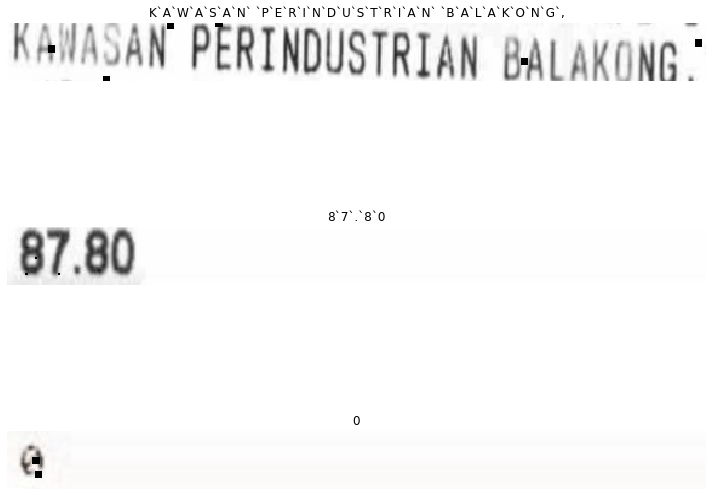

In [92]:
data.show_batch(4, figsize=(10,10))

In [93]:
dl = iter(data.valid_dl)
i, o = next(dl)
i.shape

torch.Size([8, 3, 48, 794])

In [94]:
data.c

70

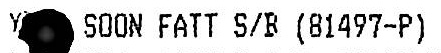

In [95]:
data.x[0]

In [96]:
data.y[0]

MultiCategory Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`9`7`-`P`)

In [97]:
data.y[0].data

tensor([59,  2, 53, 49, 49, 48,  2, 40, 35, 54, 54,  2, 53, 17, 36,  2, 10, 26,
        19, 22, 27, 25, 15, 50, 11])

### Learner

In [98]:
def loss_func(y_pred, y_true):
    # y_pred: [b,s_d,c], y_true: [b,s_d]
    mask = y_true != pad_idx
    return CrossEntropyFlat()(y_pred[mask], y_true[mask])

In [99]:
pad_idx = data.classes.index(label_delim)
ctc_loss = nn.CTCLoss(blank=pad_idx, reduction='mean', zero_infinity=True)

In [100]:
#export

def loss_func(y_pred, y_true, y_pred_len, y_true_len):
    # y_pred: [b,s_e,c], y_true: [[s_d], [s_d], ...], lengths: [b]
    b, s_e, c = y_pred.shape
    y_true = torch.cat(y_true, axis=0) # [b*s_d]
    y_pred = y_pred.log_softmax(axis=2).permute(1,0,2) # [ s_e, b, c ]
#     torch.backends.cudnn.enabled = False
    loss = ctc_loss(y_pred, y_true, y_pred_len, y_true_len)
#     torch.backends.cudnn.enabled = True
    return loss

In [101]:
#export
def wer(s1,s2):
    ''' s1 - true text, s2 - pred text '''
    d = np.zeros([len(s1)+1,len(s2)+1])
    d[:,0] = np.arange(len(s1)+1)
    d[0,:] = np.arange(len(s2)+1)

    for j in range(1,len(s2)+1):
        for i in range(1,len(s1)+1):
            if s1[i-1] == s2[j-1]:
                d[i,j] = d[i-1,j-1]
            else:
                d[i,j] = min(d[i-1,j]+1, d[i,j-1]+1, d[i-1,j-1]+1)

    return d[-1,-1]/len(s1)

word_error = wer( 'black frog jumped away'.split(' '), 'black frog jumped awayyy'.split(' ') )
char_error = wer( 'black frog jumped away', 'black frog jumped awayyy' )
char_error, word_error

(0.09090909090909091, 0.25)

In [102]:
#export
def decode_ctc(texts, classes):
    """ convert text-index into text-label. (make sure len(t) doesnt throw length of 0-dim error) """
    out = []
    index = 0
    for t in texts:
        char_list = []
        for i in range(len(t)):
            if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):  # removing repeated characters and blank.
                char_list.append(t[i])
#         text = ''.join(char_list)

        out.append(tensor(char_list))
    return out

In [103]:
decode = partial(decode_ctc, classes=data.classes)

In [104]:
#export
def CER(y_pred, y_true, y_pred_len, y_true_len):
    # y_pred: [b,s_e,c], y_true: [[s_d], [s_d], ...], lengths: [b]
    y_pred = y_pred.argmax(-1)
    y_pred = decode(y_pred)
    m = 0
    for yp, p_len, yt in zip(y_pred, y_pred_len, y_true):
        if yp.shape == torch.Size([]): continue
        yt_text = ''.join([learner.data.classes[i] for i in yt])
        yp_text = ''.join([learner.data.classes[i] for i in yp])
        m += wer(yt_text, yp_text)
    return tensor(m / len(y_pred))

#export
def WER(y_pred, y_true, y_pred_len, y_true_len):
    # y_pred: [b,s_e,c], y_true: [[s_d], [s_d], ...], lengths: [b]
    y_pred = y_pred.argmax(-1)
    y_pred = decode(y_pred)
    m = 0
    for yp, p_len, yt in zip(y_pred, y_pred_len, y_true):
        if yp.shape == torch.Size([]): continue
        yt_text = ''.join([learner.data.classes[i] for i in yt])
        yp_text = ''.join([learner.data.classes[i] for i in yp])
        m += wer(yt_text.split(' '), yp_text.split(' '))
    return tensor(m / len(y_pred))

In [111]:
# either load or create new learner
learner = load_inference('attention_ocr')
learner.data = data

In [106]:
data = create_data(main_df, bs=8)
model = ATTMODEL(nclass=data.c, n_layers=3)
pad_idx = data.classes.index(label_delim)

In [107]:
learner = Learner(data, model, loss_func=loss_func, metrics=[CER, WER])
learner.callbacks.append(ShowGraph(learner))

# learner.show_results(DatasetType.Train, rows=1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-05
Min loss divided by 10: 1.00E-02


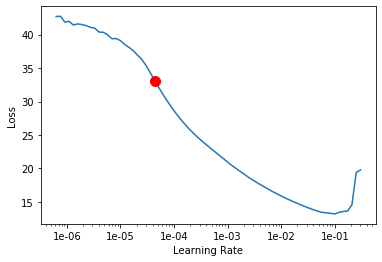

In [108]:
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)

epoch,train_loss,valid_loss,CER,WER,time
0,0.237017,0.349695,0.100225,0.413914,11:55


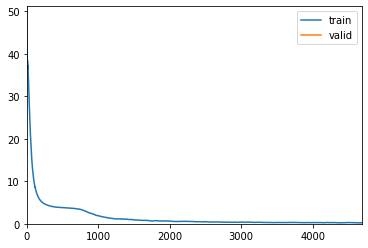

In [109]:
learner.fit_one_cycle(1, 1e-4)

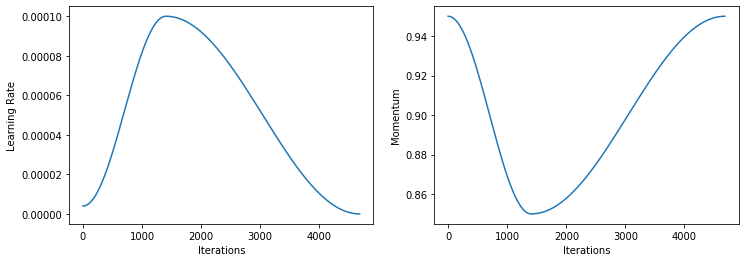

In [69]:
learner.recorder.plot_lr(show_moms=True)

epoch,train_loss,valid_loss,CER,WER,time
0,0.240205,0.323071,0.089470,0.368143,11:57
1,0.102594,0.188289,0.052375,0.246102,11:58


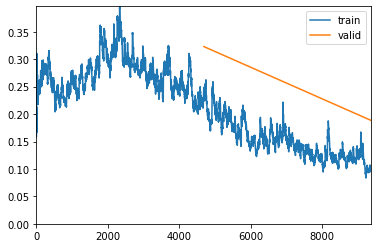

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [113]:
learner.fit_one_cycle(2, 1e-4)

In [70]:
learner.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,CER,WER,time
0,0.202908,0.196617,0.054401,0.243422,12:44
1,0.230875,0.230261,0.062382,0.299656,12:44
2,0.184453,0.184768,0.050692,0.239707,12:43
3,0.119743,0.148107,0.037876,0.177147,12:47
4,0.089449,0.112572,0.027303,0.140700,12:47
5,0.097496,0.104368,0.024799,0.117317,12:48
6,0.066068,0.087686,0.021050,0.104705,12:47
7,0.045882,0.078434,0.017442,0.090925,12:50
8,0.033603,0.075237,0.016991,0.086048,12:48
9,0.040141,0.074169,0.016440,0.082840,12:49


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [114]:
save_inference(learner, 'attention_ocr')

### Examples

In [115]:
learner = load_inference('attention_ocr')
learner.data = data

In [116]:
# for fn in easy_df[:1]['image_path']:
#     im = open_image(os.path.join(DATA_PATH, fn))
#     batch = learner.data.one_item(im)
#     preds = learner.model.eval()(batch[0]).squeeze().argmax(-1)
#     indexes = [int(i) for i in decode([preds])[0]]
#     print(''.join([learner.data.classes[i] for i in indexes]))

In [117]:
# learner.show_results(DatasetType.Train, rows=1) # DOESNT WORK

In [118]:
dl = iter(learner.data.valid_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PRED: ````````1`````````````````````````6```````````````````````G``````````````````````` ` `````````````````B```````````L`L```````````````````````````````O`````````````````````C`````````````````K`K````````````````````````` ` ```````````````````B```````````````````````````````````````````````.`````````````Z`Z`````````````````````````E`E`````````````````````N`N`````````````I`````````````````````T`````````````````````````````H``````````````````````` ```````````````````C```````````````````````O```````````````````R`R`````````````````````P```````````````````````O```````````````````R`R```````````````````A`````````````````T`````````````````````````````E``````````````````````` ```````````````````P```````````````````A`A`````````````````````R`R`````````````````K`K````````````````````````````````
TRUE: 1`6`G` `B`L`O`C`K` `B` `,`Z`E`N`I`T`H` `C`O`R`P`O`R`A`T`E` `P`A`R`K


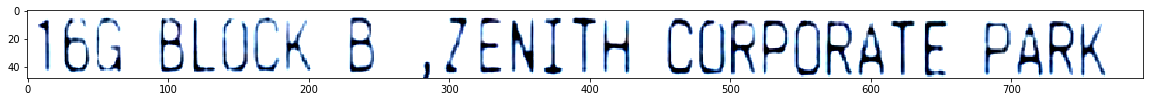

In [119]:
model = learner.model
model = model.eval()
a = next(dl)
i = 1
y_pred = model(a[0])
o = y_pred.argmax(-1)[i].cpu().numpy()
print('PRED:', MultiCategory(one_hot_text(o, data.c), [data.classes[p] for p in o], o))
print('TRUE:', MultiCategory(a[1], [data.classes[p] for p in a[1][0][i]], o))
plt.figure(figsize = (20,2))
_ = plt.imshow(a[0][i].permute(1,2,0).cpu().numpy(), interpolation='nearest')

In [120]:
''.join([data.classes[i] for i in decode([o])[0]])

'16G BLOCK B.ZENITH CORPORATE PARK'

### Eval

In [70]:
def calc_precision_recall(true_words, pred_words):
    num_preds, num_trues = len(pred_words), len(true_words)
    
    correct = 0
    for true_word in true_words:
        if true_word in pred_words:
            pred_words.remove(true_word)
            correct += 1
            continue

    precision = correct / num_preds
    recall = correct / num_trues
    # print(precision, recall, correct, num_preds)
    return precision, recall

In [71]:
def wer(s1,s2):
    ''' s1 - true text, s2 - pred text '''
    d = np.zeros([len(s1)+1,len(s2)+1])
    d[:,0] = np.arange(len(s1)+1)
    d[0,:] = np.arange(len(s2)+1)

    for j in range(1,len(s2)+1):
        for i in range(1,len(s1)+1):
            if s1[i-1] == s2[j-1]:
                d[i,j] = d[i-1,j-1]
            else:
                d[i,j] = min(d[i-1,j]+1, d[i,j-1]+1, d[i-1,j-1]+1)

    return d[-1,-1]/len(s1)

word_error = wer( 'black frog jumped away'.split(' '), 'black frog jumped awayyy'.split(' ') )
char_error = wer( 'black frog jumped away', 'black frog jumped awayyy' )
char_error, word_error

(0.09090909090909091, 0.25)

In [72]:
def idx2text(indexes):
    for i in indexes:
        try:
            data.classes[i]
        except:
            print('asd', i)
    return ''.join([data.classes[i] for i in indexes])

In [73]:
def evaluate_model(model, dl, t2list=lambda t: list(t.cpu().numpy()), total=None):
    total = len(dl) if total is None else total
    errors = 0
    ps, rs, ws, cs = [], [], [], []
    for images, (texts, im_lens, text_lens) in tqdm(iter(dl), total=total):
        y_pred = model(images).argmax(-1)
        pred_texts = decode(y_pred)
        for true_words, pred_words in zip(texts, pred_texts): # go through batch
            if list(pred_words.shape) == []:
#                 print('list(pred_words.shape) == []')
                errors += 1
                continue
            true_words, pred_words = t2list(true_words), t2list(pred_words)
            true_str, pred_str = idx2text(true_words), idx2text(pred_words)
            p,r = calc_precision_recall(true_words, pred_words)
            c = wer(true_str, pred_str)
            w = wer(true_str.split(' '), pred_str.split(' '))
            ps.append(p); rs.append(r); ws.append(w); cs.append(c)
    print('errors:', errors)
    return np.array(ps), np.array(rs), np.array(ws), np.array(cs)

# p, r, w, c = evaluate_model(learner.model.train(), data.valid_dl)

In [74]:
model = learner.model.eval()

In [75]:
p, r, w, c = evaluate_model(model, learner.data.train_dl)
c.mean(), w.mean(), p.mean(), r.mean()


errors: 2


(0.007755478969301162,
 0.04339869379501086,
 0.9956939948055978,
 0.9947688724869667)

In [76]:
p, r, w, c = evaluate_model(model, learner.data.valid_dl)
c.mean(), w.mean(), p.mean(), r.mean()


errors: 9


(0.01527761868750126,
 0.07418353684529119,
 0.9913311770598332,
 0.9895199015760962)